## Imports

In [45]:
import math
import random
import statistics
from dataclasses import dataclass
from typing import Callable, Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd




## Benchmark functions

In [46]:
# === Benchmark functions ===

def sphere(x: np.ndarray) -> float:
    """Sphere: global min 0 at x = 0."""
    return float(np.sum(x ** 2))


def rosenbrock(x: np.ndarray) -> float:
    """
    Rosenbrock: global min 0 at x = 1.
    f(x) = sum_{i=1}^{n-1} [100 (x_{i+1} - x_i^2)^2 + (1 - x_i)^2]
    """
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 +
                        (1.0 - x[:-1]) ** 2.0))


def rastrigin(x: np.ndarray) -> float:
    """Rastrigin: global min 0 at x = 0 (multimodal)."""
    n = x.size
    return float(10.0 * n + np.sum(x ** 2 - 10.0 * np.cos(2.0 * np.pi * x)))


def ackley(x: np.ndarray) -> float:
    """Ackley: global min 0 at x = 0 (multimodal)."""
    n = x.size
    sum_sq = np.sum(x ** 2)
    sum_cos = np.sum(np.cos(2.0 * np.pi * x))
    term1 = -20.0 * math.exp(-0.2 * math.sqrt(sum_sq / n))
    term2 = -math.exp(sum_cos / n)
    return float(term1 + term2 + 20.0 + math.e)


# === Bounds for each function ===
BOUNDS: Dict[str, Tuple[float, float]] = {
    "sphere": (-5.12, 5.12),
    "rosenbrock": (-5.0, 10.0),
    "rastrigin": (-5.12, 5.12),
    "ackley": (-32.768, 32.768),
}

# === Success thresholds for stopping & success-rate ===
THRESHOLDS: Dict[str, float] = {
    "sphere": 1e-8,       # tiny for easy convex functions
    "rosenbrock": 1e-8,
    "rastrigin": 1e-4,    # looser for hard multimodal
    "ackley": 1e-4,
}


## PSO Configuration and Single-Run Implementation

In [47]:
@dataclass
class PSOConfig:
    # PSO parameters
    w: float = 0.7            # inertia
    c1: float = 1.5           # cognitive
    c2: float = 1.5           # social

    # Budget
    swarm_size: int = 30
    max_iters: int = 300
    max_evals: int = 30000

    # Initialization & velocity handling
    vel_range_frac: float = 0.15   # init |v| in ~10–20% of range
    vel_clamp_frac: float = 0.5    # |v| <= 0.5 * (upper - lower)


@dataclass
class RunResult:
    best_fitness: float
    best_position: np.ndarray
    evals_used: int
    gbest_history: List[float]     # per-iteration best fitness
    success: bool                  # hit threshold or not


def pso_minimize(
    func: Callable[[np.ndarray], float],
    dim: int,
    bounds: Tuple[float, float],
    threshold: float,
    cfg: PSOConfig,
    seed: int = 0
) -> RunResult:
    """
    Single PSO run on a given function & dimension.
    Respects:
    - bounds
    - max_iters / max_evals
    - threshold
    - reproducible via seed
    """

    # Reproducibility
    random.seed(seed)
    np.random.seed(seed)

    low, high = bounds
    span = high - low

    # Swarm size: 30 normally, 50 for n=30
    swarm_size = cfg.swarm_size
    if dim == 30:
        swarm_size = max(swarm_size, 50)

    # --- Initialization ---
    positions = np.random.uniform(low, high, size=(swarm_size, dim))
    v_init_max = cfg.vel_range_frac * span
    velocities = np.random.uniform(-v_init_max, v_init_max,
                                   size=(swarm_size, dim))

    # Personal bests
    pbest_positions = positions.copy()
    pbest_values = np.apply_along_axis(func, 1, positions)
    evals = swarm_size

    # Global best
    best_idx = int(np.argmin(pbest_values))
    gbest_position = pbest_positions[best_idx].copy()
    gbest_value = float(pbest_values[best_idx])

    gbest_history = [gbest_value]  # record per-iteration best
    v_clamp = cfg.vel_clamp_frac * span

    # --- Main PSO loop ---
    for _ in range(cfg.max_iters):

        # Stopping conditions: budget or threshold
        if evals >= cfg.max_evals:
            break
        if gbest_value <= threshold:
            break

        # Random factors
        r1 = np.random.rand(swarm_size, dim)
        r2 = np.random.rand(swarm_size, dim)

        # Velocity update
        cognitive = cfg.c1 * r1 * (pbest_positions - positions)
        social = cfg.c2 * r2 * (gbest_position - positions)
        velocities = cfg.w * velocities + cognitive + social

        # Velocity clamp
        velocities = np.clip(velocities, -v_clamp, v_clamp)

        # Position update + bounds
        positions = positions + velocities
        positions = np.clip(positions, low, high)

        # Evaluate
        fitness = np.apply_along_axis(func, 1, positions)
        evals += swarm_size

        # Update personal bests
        better = fitness < pbest_values
        pbest_values[better] = fitness[better]
        pbest_positions[better] = positions[better]

        # Update global best
        best_idx = int(np.argmin(pbest_values))
        if pbest_values[best_idx] < gbest_value:
            gbest_value = float(pbest_values[best_idx])
            gbest_position = pbest_positions[best_idx].copy()

        # Record best fitness for this iteration
        gbest_history.append(gbest_value)

    # -------- Hybrid Local Search Refinement --------
    # Try to improve the global best using Nelder–Mead
    refined_pos, refined_fit = hybrid_local_search(func, gbest_position)

    # If local search improves the result, update the global best
    if refined_fit < gbest_value:
        gbest_position = refined_pos
        gbest_value = refined_fit

    # Determine success after refinement
    success = gbest_value <= threshold

    # -------- Final return --------
    return RunResult(
        best_fitness=gbest_value,
        best_position=gbest_position,
        evals_used=evals,
        gbest_history=gbest_history,
        success=success,
    )


## Hybrid Local Search (Nelder–Mead Refinement)

In [48]:
from scipy.optimize import minimize

def hybrid_local_search(func, best_pos):
    """
    Apply a gradient-free local optimization (Nelder–Mead)
    starting from the global best solution found by PSO.

    Parameters:
        func (callable): Objective function to minimize.
        best_pos (array-like): The current global best position.

    Returns:
        refined_pos (np.ndarray): Improved solution after local search.
        refined_fit (float): Fitness value at the refined solution.
    """

    result = minimize(
        fun=func,
        x0=np.array(best_pos, dtype=float),
        method="Nelder-Mead",
        options={
            "maxiter": 200,     # Maximum number of local search iterations
            "adaptive": True    # Use adaptive step size
        }
    )

    return result.x, result.fun


## Local-Best PSO Implementation (lbest Topology)

In [49]:
def pso_minimize_lbest(
    func: Callable[[np.ndarray], float],
    dim: int,
    bounds: Tuple[float, float],
    threshold: float,
    cfg: PSOConfig,
    seed: int = 0
) -> RunResult:
    """
    PSO with local best (lbest) topology: each particle sees the best of
    itself and its two neighbors in a ring.
    """

    random.seed(seed)
    np.random.seed(seed)

    low, high = bounds
    span = high - low

    swarm_size = cfg.swarm_size
    if dim == 30:
        swarm_size = max(swarm_size, 50)

    # Initialization
    positions = np.random.uniform(low, high, size=(swarm_size, dim))
    v_init_max = cfg.vel_range_frac * span
    velocities = np.random.uniform(-v_init_max, v_init_max,
                                   size=(swarm_size, dim))

    # Personal bests
    pbest_positions = positions.copy()
    pbest_values = np.apply_along_axis(func, 1, positions)
    evals = swarm_size

    # For logging, we can also use the global best (min of all lbest)
    best_idx = int(np.argmin(pbest_values))
    gbest_value = float(pbest_values[best_idx])
    gbest_position = pbest_positions[best_idx].copy()

    gbest_history = [gbest_value]
    v_clamp = cfg.vel_clamp_frac * span

    # --- Main PSO loop ---
    for _ in range(cfg.max_iters):

        if evals >= cfg.max_evals:
            break
        if gbest_value <= threshold:
            break

        # Compute local best for each particle (ring topology)
        lbest_positions = np.zeros_like(positions)
        for i in range(swarm_size):
            left = (i - 1) % swarm_size
            right = (i + 1) % swarm_size
            neigh_idx = [left, i, right]
            neigh_vals = pbest_values[neigh_idx]
            best_neigh = neigh_idx[int(np.argmin(neigh_vals))]
            lbest_positions[i] = pbest_positions[best_neigh]

        # Random factors
        r1 = np.random.rand(swarm_size, dim)
        r2 = np.random.rand(swarm_size, dim)

        # Velocity update: social term uses lbest instead of global best
        cognitive = cfg.c1 * r1 * (pbest_positions - positions)
        social = cfg.c2 * r2 * (lbest_positions - positions)
        velocities = cfg.w * velocities + cognitive + social

        # Clamp velocity
        velocities = np.clip(velocities, -v_clamp, v_clamp)

        # Position update
        positions = positions + velocities
        positions = np.clip(positions, low, high)

        # Evaluate
        fitness = np.apply_along_axis(func, 1, positions)
        evals += swarm_size

        # Personal best update
        better = fitness < pbest_values
        pbest_values[better] = fitness[better]
        pbest_positions[better] = positions[better]

        # Logging global best (min over all particles)
        best_idx = int(np.argmin(pbest_values))
        if pbest_values[best_idx] < gbest_value:
            gbest_value = float(pbest_values[best_idx])
            gbest_position = pbest_positions[best_idx].copy()

        gbest_history.append(gbest_value)

    # (Optional) you could also add hybrid_local_search here for lbest,
    # but for a clearer comparison we keep this pure PSO.
    success = gbest_value <= threshold

    return RunResult(
        best_fitness=gbest_value,
        best_position=gbest_position,
        evals_used=evals,
        gbest_history=gbest_history,
        success=success,
    )


## Run Full PSO Experiment Suite

In [50]:
def run_experiments(
    runs_per_setting: int = 30,
    dims = (2, 10, 30),
    cfg: PSOConfig = PSOConfig()
):
    functions: Dict[str, Callable[[np.ndarray], float]] = {
        "sphere": sphere,
        "rosenbrock": rosenbrock,
        "rastrigin": rastrigin,
        "ackley": ackley,
    }

    all_results: Dict[str, Dict[int, List[RunResult]]] = {}
    summary_rows = []

    for fname, f in functions.items():
        print("=" * 70)
        print(f"Function: {fname}")
        all_results[fname] = {}

        for dim in dims:
            print(f"\n  Dimension n = {dim}")
            results: List[RunResult] = []

            for run_id in range(runs_per_setting):
                seed = 1234 + run_id  # reproducible independent runs
                res = pso_minimize(
                    func=f,
                    dim=dim,
                    bounds=BOUNDS[fname],
                    threshold=THRESHOLDS[fname],
                    cfg=cfg,
                    seed=seed,
                )
                results.append(res)

            final_vals = [r.best_fitness for r in results]
            successes = [r.success for r in results]

            mean_val = statistics.mean(final_vals)
            median_val = statistics.median(final_vals)
            best_val = min(final_vals)
            worst_val = max(final_vals)
            std_val = statistics.pstdev(final_vals)
            success_rate = sum(successes) / len(successes)

            print(f"    mean fitness   : {mean_val:.6e}")
            print(f"    median fitness : {median_val:.6e}")
            print(f"    best fitness   : {best_val:.6e}")
            print(f"    worst fitness  : {worst_val:.6e}")
            print(f"    std dev        : {std_val:.6e}")
            print(f"    success rate   : {success_rate*100:.1f}% "
                  f"(threshold {THRESHOLDS[fname]:.1e})")

            all_results[fname][dim] = results

            summary_rows.append({
                "function": fname,
                "dim": dim,
                "mean_final": mean_val,
                "median_final": median_val,
                "best_final": best_val,
                "worst_final": worst_val,
                "std_final": std_val,
                "success_rate": success_rate,
            })

    summary_df = pd.DataFrame(summary_rows)
    return all_results, summary_df


## Main Experiment Execution

In [51]:
# === Run main PSO experiments (all functions, n = 2, 10, 30) ===

cfg = PSOConfig()  # assignment defaults
results, summary_df = run_experiments(
    runs_per_setting=30,
    dims=(2, 10, 30),
    cfg=cfg
)

summary_df


Function: sphere

  Dimension n = 2
    mean fitness   : 4.516082e-09
    median fitness : 4.345557e-09
    best fitness   : 1.398399e-10
    worst fitness  : 9.341092e-09
    std dev        : 2.864727e-09
    success rate   : 100.0% (threshold 1.0e-08)

  Dimension n = 10
    mean fitness   : 8.620147e-09
    median fitness : 9.042255e-09
    best fitness   : 6.287311e-09
    worst fitness  : 9.881270e-09
    std dev        : 1.132682e-09
    success rate   : 100.0% (threshold 1.0e-08)

  Dimension n = 30
    mean fitness   : 4.688661e-01
    median fitness : 1.171672e-06
    best fitness   : 2.624886e-08
    worst fitness  : 1.406581e+01
    std dev        : 2.524889e+00
    success rate   : 0.0% (threshold 1.0e-08)
Function: rosenbrock

  Dimension n = 2
    mean fitness   : 4.124240e-10
    median fitness : 3.017802e-10
    best fitness   : 7.088848e-11
    worst fitness  : 1.804384e-09
    std dev        : 3.572845e-10
    success rate   : 100.0% (threshold 1.0e-08)

  Dimension n

,function,dim,mean_final,median_final,best_final,worst_final,std_final,success_rate
0,sphere,2,4.516082e-09,4.345557e-09,1.398399e-10,9.341092e-09,2.864727e-09,1.0
1,sphere,10,8.620147e-09,9.042255e-09,6.287311e-09,9.881270e-09,1.132682e-09,1.0
2,sphere,30,4.688661e-01,1.171672e-06,2.624886e-08,1.406581e+01,2.524889e+00,0.0
3,rosenbrock,2,4.124240e-10,3.017802e-10,7.088848e-11,1.804384e-09,3.572845e-10,1.0
4,rosenbrock,10,9.204860e+00,3.831980e+00,1.077252e-01,8.149309e+01,1.941974e+01,0.0
5,rosenbrock,30,3.273051e+03,7.966015e+01,1.383844e+01,1.855585e+04,6.397084e+03,0.0
6,rastrigin,2,4.811611e-05,4.543711e-05,1.982761e-06,9.831821e-05,2.887353e-05,1.0
7,rastrigin,10,9.551674e+00,8.954627e+00,3.979836e+00,3.581826e+01,5.821890e+00,0.0
8,rastrigin,30,8.551811e+01,8.023155e+01,3.681372e+01,1.373128e+02,2.830583e+01,0.0
9,ackley,2,6.696618e-05,6.714825e-05,7.215865e-06,9.884760e-05,2.487988e-05,1.0


## Parameter Study

In [52]:
# === Parameter study for (w, c1, c2) on n = 10 ===

param_configs = [
    ("default", PSOConfig(w=0.7, c1=1.5, c2=1.5)),
    ("more_inertia", PSOConfig(w=0.9, c1=1.5, c2=1.5)),
    ("more_exploration", PSOConfig(w=0.7, c1=2.0, c2=2.0)),
    ("more_exploitation", PSOConfig(w=0.4, c1=2.5, c2=2.5)),
]

param_rows = []

dim = 10
functions = {
    "sphere": sphere,
    "rosenbrock": rosenbrock,
    "rastrigin": rastrigin,
    "ackley": ackley,
}

for label, cfg_p in param_configs:
    print("=" * 70)
    print(f"Parameter setting: {label} (w={cfg_p.w}, c1={cfg_p.c1}, c2={cfg_p.c2})")

    for fname, f in functions.items():
        results_p = []
        for run_id in range(30):
            seed = 4321 + run_id
            res = pso_minimize(
                func=f,
                dim=dim,
                bounds=BOUNDS[fname],
                threshold=THRESHOLDS[fname],
                cfg=cfg_p,
                seed=seed,
            )
            results_p.append(res)

        final_vals = [r.best_fitness for r in results_p]

        row = {
            "setting": label,
            "function": fname,
            "dim": dim,
            "mean_final": statistics.mean(final_vals),
            "median_final": statistics.median(final_vals),
            "best_final": min(final_vals),
            "worst_final": max(final_vals),
            "std_final": statistics.pstdev(final_vals),
        }
        param_rows.append(row)

param_df = pd.DataFrame(param_rows)
param_df


Parameter setting: default (w=0.7, c1=1.5, c2=1.5)
Parameter setting: more_inertia (w=0.9, c1=1.5, c2=1.5)
Parameter setting: more_exploration (w=0.7, c1=2.0, c2=2.0)
Parameter setting: more_exploitation (w=0.4, c1=2.5, c2=2.5)


,setting,function,dim,mean_final,median_final,best_final,worst_final,std_final
0,default,sphere,10,7.816921e-09,8.012282e-09,3.028924e-09,9.858918e-09,1.635008e-09
1,default,rosenbrock,10,5.052398e+00,3.779248e+00,1.548256e-01,4.054625e+01,6.837228e+00
2,default,rastrigin,10,9.023740e+00,7.991387e+00,1.989918e+00,1.989908e+01,4.572225e+00
3,default,ackley,10,3.859201e-02,9.013111e-05,7.586035e-05,1.155149e+00,2.073393e-01
4,more_inertia,sphere,10,7.144616e-02,6.049819e-02,3.879262e-03,3.550723e-01,6.859946e-02
5,more_inertia,rosenbrock,10,5.002602e+01,3.078015e+01,4.389826e+00,1.832601e+02,4.539269e+01
6,more_inertia,rastrigin,10,2.003336e+01,1.867351e+01,7.080522e+00,4.154026e+01,8.143335e+00
7,more_inertia,ackley,10,5.773601e+00,5.406470e+00,3.998002e+00,8.644607e+00,1.197448e+00
8,more_exploration,sphere,10,5.041426e-05,2.910046e-05,9.796279e-07,2.310944e-04,5.756799e-05
9,more_exploration,rosenbrock,10,1.143816e+01,7.030642e+00,1.466551e+00,8.042544e+01,1.826972e+01


## Comparison of Global-Best (gbest) and Local-Best (lbest) PSO

In [53]:
# === gbest vs lbest comparison (example on Rastrigin, n = 10) ===

compare_dim = 10
fname = "rastrigin"
func = functions[fname]

gbest_results = []
lbest_results = []

for run_id in range(30):
    seed = 999 + run_id

    res_g = pso_minimize(
        func=func,
        dim=compare_dim,
        bounds=BOUNDS[fname],
        threshold=THRESHOLDS[fname],
        cfg=PSOConfig(),
        seed=seed,
    )
    res_l = pso_minimize_lbest(
        func=func,
        dim=compare_dim,
        bounds=BOUNDS[fname],
        threshold=THRESHOLDS[fname],
        cfg=PSOConfig(),
        seed=seed,
    )

    gbest_results.append(res_g)
    lbest_results.append(res_l)

gbest_vals = [r.best_fitness for r in gbest_results]
lbest_vals = [r.best_fitness for r in lbest_results]

print(f"{fname} n={compare_dim}")
print(f"  gbest  mean final: {statistics.mean(gbest_vals):.3e}")
print(f"  lbest  mean final: {statistics.mean(lbest_vals):.3e}")
print(f"  gbest  best final: {min(gbest_vals):.3e}")
print(f"  lbest  best final: {min(lbest_vals):.3e}")


rastrigin n=10
  gbest  mean final: 9.986e+00
  lbest  mean final: 9.370e+00
  gbest  best final: 1.993e+00
  lbest  best final: 4.999e+00


## Plot Convergence Curve for a Single Run


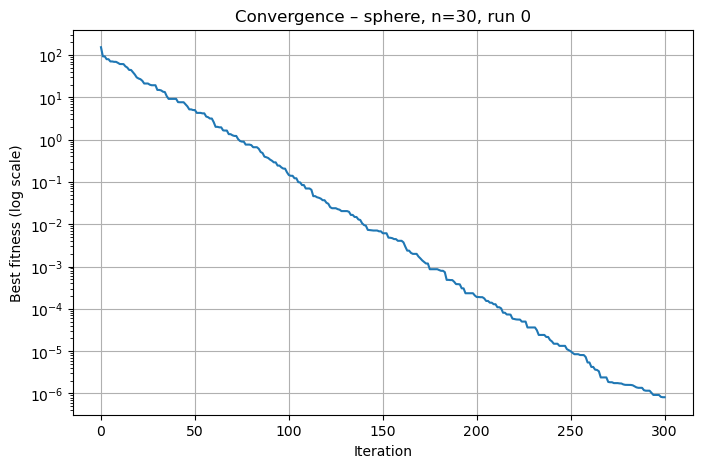

In [54]:
func_name = "sphere"
dim = 30

example_run = results[func_name][dim][0]  # first run
gbest_hist = example_run.gbest_history

plt.figure(figsize=(8, 5))
plt.semilogy(gbest_hist)
plt.xlabel("Iteration")
plt.ylabel("Best fitness (log scale)")
plt.title(f"Convergence – {func_name}, n={dim}, run 0")
plt.grid(True)
plt.show()


## Plot Average Convergence Curves Across All Functions


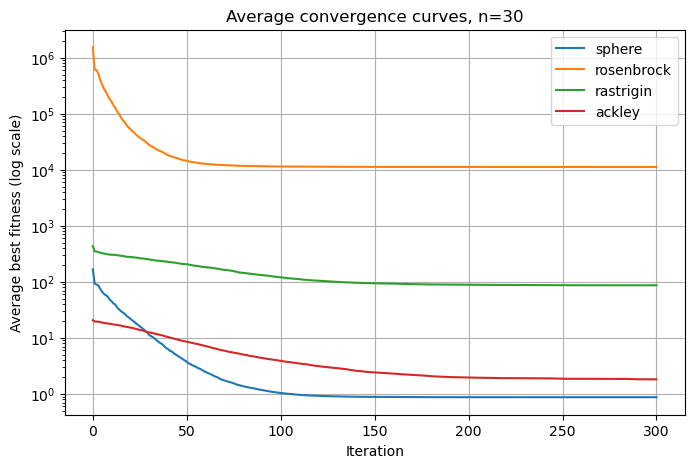

In [55]:
def plot_average_convergence(results, dim: int, functions=None):
    if functions is None:
        functions = ["sphere", "rosenbrock", "rastrigin", "ackley"]

    plt.figure(figsize=(8, 5))

    for fname in functions:
        runs = results[fname][dim]
        # Make all gbest histories the same length by padding with last value
        max_len = max(len(r.gbest_history) for r in runs)
        padded = []
        for r in runs:
            h = r.gbest_history
            if len(h) < max_len:
                h = h + [h[-1]] * (max_len - len(h))
            padded.append(h)
        avg_hist = np.mean(padded, axis=0)
        plt.semilogy(avg_hist, label=fname)

    plt.xlabel("Iteration")
    plt.ylabel("Average best fitness (log scale)")
    plt.title(f"Average convergence curves, n={dim}")
    plt.grid(True)
    plt.legend()
    plt.show()


# Example: compare all functions at n = 30
plot_average_convergence(results, dim=30)


## Plot Final Fitness Distribution (Boxplot)


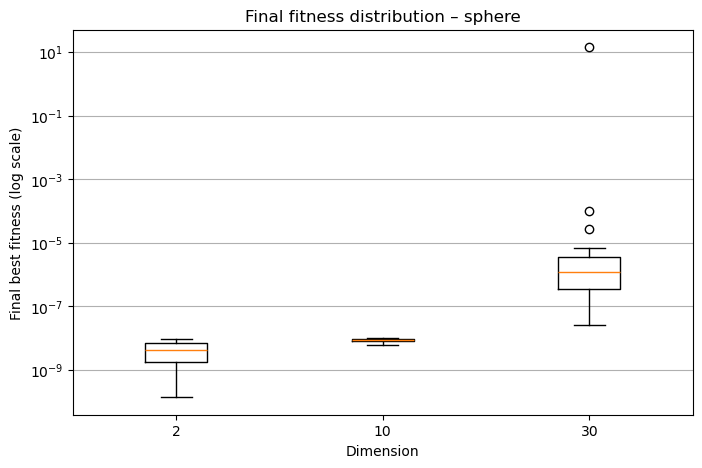

In [56]:
def boxplot_final_fitness(results, func_name: str):
    dims = sorted(results[func_name].keys())
    data = [ [r.best_fitness for r in results[func_name][d]] for d in dims ]

    plt.figure(figsize=(8, 5))
    plt.boxplot(data, labels=[str(d) for d in dims])
    plt.yscale("log")
    plt.xlabel("Dimension")
    plt.ylabel("Final best fitness (log scale)")
    plt.title(f"Final fitness distribution – {func_name}")
    plt.grid(True, axis="y")
    plt.show()


# Example: check Sphere across dims 2, 10, 30
boxplot_final_fitness(results, "sphere")


## Local Search Refinement Using Random Perturbations


In [57]:
def local_search_random(func, x0, radius=0.05, steps=200):
    """
    Simple gradient-free local search around x0.
    Tries random perturbations in a hypercube of given radius.
    """
    x_best = x0.copy()
    f_best = func(x_best)

    for _ in range(steps):
        candidate = x_best + np.random.uniform(-radius, radius, size=x0.shape)
        f_cand = func(candidate)
        if f_cand < f_best:
            f_best = f_cand
            x_best = candidate

    return x_best, f_best


# Example: refine a PSO solution on Sphere (n=30)
example_run = results["sphere"][30][0]
x_pso = example_run.best_position
f_pso = example_run.best_fitness

x_ls, f_ls = local_search_random(sphere, x_pso, radius=0.05, steps=200)

print("Before local search:", f_pso)
print("After  local search:", f_ls)


Before local search: 8.149539099375349e-07
After  local search: 8.149539099375349e-07


## Run Full Experiment Suite and Display Summary Table


In [58]:
cfg = PSOConfig()  # assignment defaults
results, summary_df = run_experiments(
    runs_per_setting=30,
    dims=(2, 10, 30),
    cfg=cfg
)

summary_df


Function: sphere

  Dimension n = 2
    mean fitness   : 4.516082e-09
    median fitness : 4.345557e-09
    best fitness   : 1.398399e-10
    worst fitness  : 9.341092e-09
    std dev        : 2.864727e-09
    success rate   : 100.0% (threshold 1.0e-08)

  Dimension n = 10
    mean fitness   : 8.620147e-09
    median fitness : 9.042255e-09
    best fitness   : 6.287311e-09
    worst fitness  : 9.881270e-09
    std dev        : 1.132682e-09
    success rate   : 100.0% (threshold 1.0e-08)

  Dimension n = 30
    mean fitness   : 4.688661e-01
    median fitness : 1.171672e-06
    best fitness   : 2.624886e-08
    worst fitness  : 1.406581e+01
    std dev        : 2.524889e+00
    success rate   : 0.0% (threshold 1.0e-08)
Function: rosenbrock

  Dimension n = 2
    mean fitness   : 4.124240e-10
    median fitness : 3.017802e-10
    best fitness   : 7.088848e-11
    worst fitness  : 1.804384e-09
    std dev        : 3.572845e-10
    success rate   : 100.0% (threshold 1.0e-08)

  Dimension n

,function,dim,mean_final,median_final,best_final,worst_final,std_final,success_rate
0,sphere,2,4.516082e-09,4.345557e-09,1.398399e-10,9.341092e-09,2.864727e-09,1.0
1,sphere,10,8.620147e-09,9.042255e-09,6.287311e-09,9.881270e-09,1.132682e-09,1.0
2,sphere,30,4.688661e-01,1.171672e-06,2.624886e-08,1.406581e+01,2.524889e+00,0.0
3,rosenbrock,2,4.124240e-10,3.017802e-10,7.088848e-11,1.804384e-09,3.572845e-10,1.0
4,rosenbrock,10,9.204860e+00,3.831980e+00,1.077252e-01,8.149309e+01,1.941974e+01,0.0
5,rosenbrock,30,3.273051e+03,7.966015e+01,1.383844e+01,1.855585e+04,6.397084e+03,0.0
6,rastrigin,2,4.811611e-05,4.543711e-05,1.982761e-06,9.831821e-05,2.887353e-05,1.0
7,rastrigin,10,9.551674e+00,8.954627e+00,3.979836e+00,3.581826e+01,5.821890e+00,0.0
8,rastrigin,30,8.551811e+01,8.023155e+01,3.681372e+01,1.373128e+02,2.830583e+01,0.0
9,ackley,2,6.696618e-05,6.714825e-05,7.215865e-06,9.884760e-05,2.487988e-05,1.0
